### Plot 1

In [42]:
import numpy as np
import pandas as pd
import scipy as sp
from h_eq import solve_kappa
import warnings
warnings.filterwarnings('ignore')
from plotnine import *
warnings.resetwarnings()
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [23]:
# Find hmle
nvals = 12
gamma_values = np.arange(0, nvals)*(40 / nvals)
hmle_values = np.zeros((nvals,))
beta0 = 0
for i, gamma in enumerate(gamma_values):
    print(f"At gamma={gamma}")
    hmle_values[i] = solve_kappa(beta0=beta0, gamma0=gamma)


At gamma=0.0
At gamma=3.3333333333333335
At gamma=6.666666666666667
At gamma=10.0
At gamma=13.333333333333334
At gamma=16.666666666666668
At gamma=20.0
At gamma=23.333333333333336
At gamma=26.666666666666668
At gamma=30.0
At gamma=33.333333333333336
At gamma=36.66666666666667


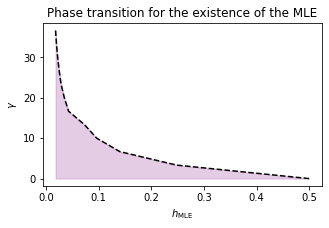

In [25]:
fig, ax = plt.subplots(figsize = (5, 3))
ax.plot(hmle_values, gamma_values, color='black', linestyle='dashed')
ax.fill_between(hmle_values, gamma_values, color='purple', alpha=0.2)
ax.set(
    xlabel=r'$h_{\mathrm{MLE}}$',
    ylabel=r'$\gamma$',
    title='Phase transition for the existence of the MLE'
)
plt.savefig("figures/hmle.png", dpi=500, bbox_inches='tight')

### Plot 2

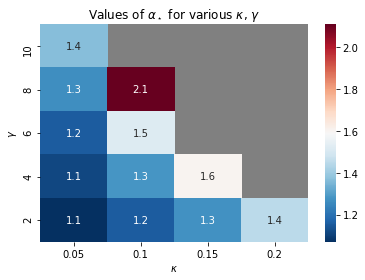

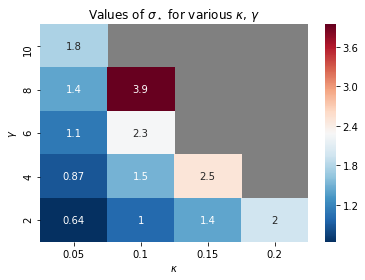

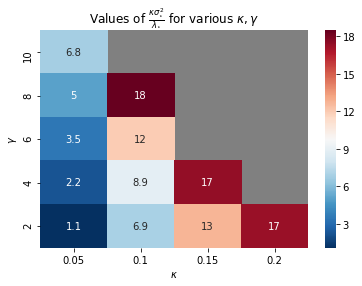

In [101]:
param_data = pd.read_csv('cache/params.csv', sep=',')
kvals = param_data['kappa'].unique()
gamma_vals = sorted(param_data['gamma'].unique(), key=lambda x: -1*x)
param_data

def construct_heatmap(param_name, title=None, ax=None):
    df = pd.DataFrame(index=kvals, columns=gamma_vals)
    for i, row in param_data.iterrows():
        df.loc[row['kappa'], row['gamma']] = float(row[param_name])

    if ax is None:
        fig, ax = plt.subplots()
    g = sns.heatmap(
        df.astype('float32').T,
        annot=True,
        cmap='RdBu_r', 
        ax=ax
    )
    g.set_facecolor('gray')
    if title is None:
        title = rf"Values of $\{param_name}_\star$ for various $\kappa$, $\gamma$"
    ax.set(
        xlabel=r'$\kappa$',
        ylabel=r'$\gamma$',
        title=title
    )

    return df


## Plot for alpha
construct_heatmap('alpha')
plt.savefig("figures/alpha.png", dpi=500, bbox_inches='tight')
plt.show()
construct_heatmap('sigma')
plt.savefig("figures/sigma.png", dpi=500, bbox_inches='tight')
plt.show()
param_data['inflation'] = param_data.index * (param_data['sigma']**2 / param_data['lambda']) 
construct_heatmap(
    'inflation', 
    title=r"Values of $\frac{\kappa \sigma_{\star}^2}{\lambda_{\star}}$ for various $\kappa, \gamma$"
)
plt.savefig("figures/inflation.png", dpi=500, bbox_inches='tight')
plt.show()

### Preprocessing for SEOCOM dataset

In [161]:
# Load
Xsecom = pd.read_csv('raw/secom.data', sep=' ', header=None)
ysecom = pd.read_csv('raw/secom_labels.data', sep=' ', header=None)

In [177]:
# Process y data (this is easy)
y = ysecom[0].copy()
y[y == -1] = 0

# Process X data (slightly trickier)
# (1) Replace missing values with their mean
X = Xsecom.fillna(Xsecom.mean(axis=0))
# (2) Scale and center
stdev = X.std(axis=0)
#stdev[stdev == 0] = 1
X = (X - X.mean()) / stdev
# (3) Eliminate columns which only have one unique value or NaNs
X = X.loc[:, (stdev.notnull()) & (stdev != 0)]
assert(X.isnull().sum().sum() == 0)

In [179]:
# Save to cache
X.to_csv('processed/secomX.csv', header=True)
y.to_csv('processed/secomy.csv', header=False)

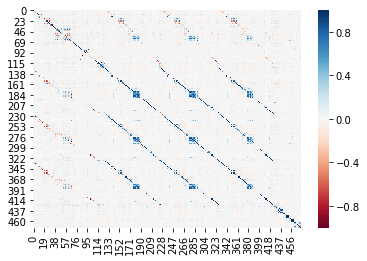

In [180]:
sns.heatmap(np.cov(X.T), cmap='RdBu')